In [1]:
from collections import defaultdict
from importlib import reload
from itertools import product
from pathlib import Path
from time import perf_counter

import sys
# current_dir = Path("__file__").resolve().parent
# src_dir = current_dir.parent / "src"
# sys.path.append(str(src_dir))

sys.path.append("../src")
import convex
import frank_wolfe
import utils
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time
import utils
from scipy.stats import pearsonr
from sklearn.cluster import KMeans
from sklearn.datasets import load_diabetes
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import MinMaxScaler
from tqdm.notebook import tqdm


[KeOps] Warning : There were warnings or errors compiling formula :
<stdin>:1:10: fatal error: cuda.h: No such file or directory
compilation terminated.

[KeOps] Warning : 
    The location of Cuda header files cuda.h and nvrtc.h could not be detected on your system.
    You must determine their location and then define the environment variable CUDA_PATH,
    either before launching Python or using os.environ before importing keops. For example
    if these files are in /vol/cuda/10.2.89-cudnn7.6.4.38/include you can do :
      import os
      os.environ['CUDA_PATH'] = '/vol/cuda/10.2.89-cudnn7.6.4.38'
    
[KeOps] Compiling cuda jit compiler engine ... 
[KeOps] Warning : There were warnings or errors compiling formula :
/home/luchar/.pyenv/versions/3.11.4/lib/python3.11/site-packages/keopscore/binders/nvrtc/nvrtc_jit.cpp:5:10: fatal error: nvrtc.h: No such file or directory
    5 | #include <nvrtc.h>
      |          ^~~~~~~~~
compilation terminated.

OK
[pyKeOps] Compiling nvrtc bin

In [2]:
V = convex.Valuator()

In [10]:
def get_error(x_b, y_b, x_s, y_s, w, k=10):
    s = w.argsort()[::-1][:k]
    x_k = x_s[s]
    y_k = y_s[s]
    beta_k = np.linalg.pinv(x_k) @ y_k
    y_hat = x_b @ beta_k

    # LR = LinearRegression(fit_intercept=False)
    # LR.fit(x_k, y_k)
    # y_hat = LR.predict(x_b)
    return mean_squared_error(y_b, y_hat)

In [4]:
reload(utils)
D = 100
data = utils.get_data(
    dataset="gaussian",
    # dataset="bone",
    # dataset="mimic",
    data_dir = "../data",
    num_buyer=100,
    num_seller=1000,
    dim=30,
)

x_s = data["X_sell"].astype(float)
y_s = data["y_sell"]
x_b = data["X_buy"].astype(float)
y_b = data["y_buy"]
x_val = data["X_val"].astype(float)
y_val = data["y_val"]
coef = data.get("coef")
# y_b = x_b @ coef

In [472]:
reload(frank_wolfe)
num_buy = 1
rang = list(range(1, 100))

err_cvx = []
err_fw = []
err_os = []
err_base = defaultdict(list)
err_rand = []

time_cvx = []
time_fw = []
time_os = []

for j in range(0, x_b.shape[0]):
    x_test = x_b[j : j + 1]
    y_test = y_b[j : j + 1]

    start = time.perf_counter()
    w_cvx = V.optimize(x_test, x_s)
    end = time.perf_counter()
    time_cvx.append(end-start)
    
    err_cvx.append([get_error(x_test, y_test, x_s, y_s, w_cvx, k) for k in rang])

    start = time.perf_counter()
    res_fw = frank_wolfe.design_selection(
        x_s, y_s,
        x_test, y_test,
        num_select=10,
        num_iters=500,
        line_search=True,
    )
    end = time.perf_counter()
    time_fw.append(end-start)
    
    w_fw = res_fw["weights"]

    start = time.perf_counter()
    w_os = frank_wolfe.one_step(x_s, x_test)
    end = time.perf_counter()
    time_os.append(end-start)

    w_base = utils.get_baseline_values(
        x_s, y_s, x_val, y_val, np.ones_like(x_val), np.ones_like(y_val),
        baselines = [
            'DataOob', 
            'DVRL', 
            'LavaEvaluator',
            'KNNShapley'
        ],
        baseline_kwargs={'DataOob': {'num_models': 100}},
    )[0]

    err_fw.append([get_error(x_test, y_test, x_s, y_s, w_fw, k) for k in rang])
    err_os.append([get_error(x_test, y_test, x_s, y_s, w_os, k) for k in rang])
    for k, v in w_base.items():
        err_base[k].append([get_error(x_test, y_test, x_s, y_s, v, k) for k in rang])
    w_rand = np.random.permutation(len(x_s))
    err_rand.append([get_error(x_test, y_test, x_s, y_s, w_rand, k) for k in rang])
    print(f'round {j} done')

NameError: name 'V' is not defined

In [11]:
color_map = {
    'Ours (multi-step)': 'C0',
    'Ours (single step)': 'C1',
    'DataOob': 'C2',
    'DataShapley': 'C3',
    'DVRL': 'C4',
    'InfluenceSubsample': 'C5',
    'KNNShapley': 'C6',
    'LavaEvaluator': 'C9',
    'LeaveOneOut': 'C8',
    'Random': 'gray',
}
label_map = {
    'Ours (multi-step)': 'Ours (multi-step)',
    'Ours (single step)': 'Ours (single step)',
    'DataOob': 'Data OOB',
    'DataShapley': 'Data Shapley',
    'DVRL': 'DVRL',
    'InfluenceSubsample': 'Influence Function',
    'KNNShapley': 'KNN Shapley',
    'LavaEvaluator': 'LAVA',
    'LeaveOneOut': 'Leave One Out',
    'Random': 'Random baseline',
}

In [49]:
def config_style(
    key, 
    ms=5,
    lw=2,
    base_marker = 'o',
    return_label=True,
):
    match key:
        case 'Random':
            lw = 5
            ls = '--'
            marker = ''
        case 'Ours (multi-step)' | 'Ours (single step)':
            ls = '-'
            marker = '*'
            ms = ms + 5
        case _:
            ls = '-'
            marker = base_marker
    ret = dict(ms=ms, lw=lw, marker=marker, ls=ls, color=color_map[key]) 
    if return_label:
        ret['label'] = label_map[key]
    return ret

In [85]:
pwd

'/u/luchar/data-markets'

In [86]:
figure_dir = Path('figures')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


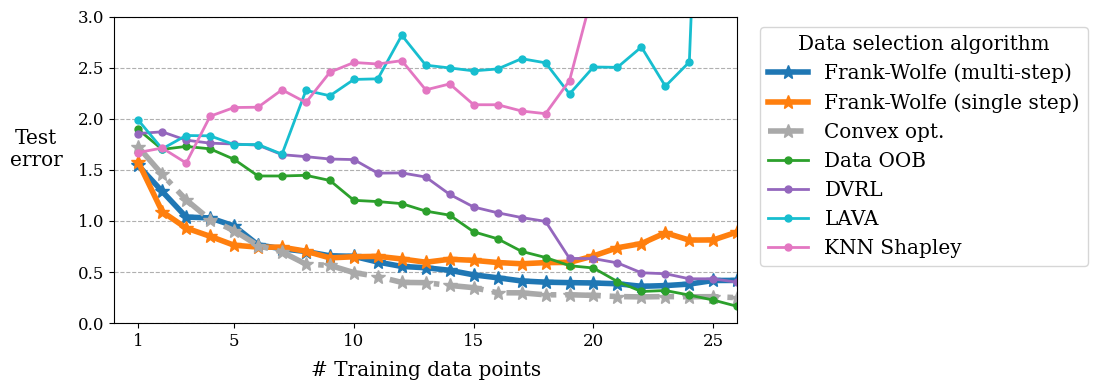

In [89]:
plt.rcParams["font.family"] = "serif"
plt.figure(figsize=(12, 4))
plt.plot(rang, np.array(err_fw).mean(0).squeeze(), label="Frank-Wolfe (multi-step)", lw=4, marker='*', ms=10)
plt.plot(rang, np.array(err_os).mean(0).squeeze(), label="Frank-Wolfe (single step)", lw=4, marker='*', ms=10)
plt.plot(rang, np.array(err_cvx).mean(0).squeeze(), label="Convex opt.", lw=4, marker='*', ms=10, c='darkgray', ls='-.')
for k, v in err_base.items():
    kwargs = config_style(k, return_label=False)
    plt.plot(rang, np.array(v).mean(0).squeeze(), label=label_map[k], **kwargs)
# plt.plot(rang, np.array(err_rand).mean(0).squeeze(), **config_style('Random'))
# plt.xlabel('Number of points selected', fontsize='x-large')
# plt.ylabel('MSE', labelpad=20, rotation=0, fontsize='x-large')
plt.legend(fontsize='x-large', bbox_to_anchor=(1.3, 1.0), loc='upper center', ncols=1, title='Data selection algorithm', title_fontsize='x-large')
plt.xlabel('# Training data points', fontsize='x-large', labelpad=8)
plt.ylabel('Test\nerror', fontsize='x-large', rotation=0, labelpad=30)
plt.grid(axis='y', ls='--')
plt.xticks([1, 5, 10, 15, 20, 25], fontsize='large')
plt.yticks(np.arange(0, 3.1, 0.5), fontsize='large')
plt.xlim(0, 26)
plt.ylim(0, 3.0)
plt.tight_layout()
plt.savefig(figure_dir / f"compare-opt.eps", bbox_inches="tight")

In [ ]:
for i in range(1, len(data)):
    plt.boxplot(data[i], vert=False, positions=[i + 1], patch_artist=True,
                boxprops=dict(facecolor=colors[i], color=colors[i]),
                medianprops=dict(color=colors[i]),
                whiskerprops=dict(color=colors[i]),
                capprops=dict(color=colors[i]),
                flierprops=dict(markeredgecolor=colors[i]))

plt.title("Horizontal Boxplot with Different Colors")
plt.xlabel("Value")
plt.yticks([1, 2, 3], ["List 1", "List 2", "List 3"])

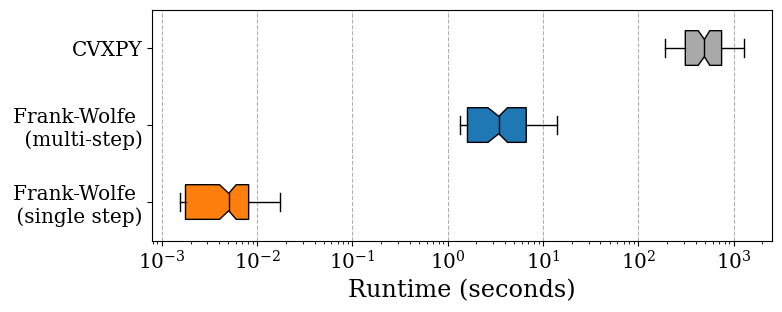

In [123]:
plt.figure(figsize=(8, 3))
colors = ['C1', 'C0', 'darkgray']
data = [
    time_os,
    time_fw,
    time_cvx,
]

for i, v in enumerate(data):
    plt.boxplot(data[i], vert=False, positions=[i + 1], patch_artist=True,
                boxprops=dict(facecolor=colors[i], color='k'),
                medianprops=dict(color='k'),
                notch=True,
                # whiskerprops=dict(color=colors[i]),
                # capprops=dict(color=colors[i]),
                # flierprops=dict(markeredgecolor=colors[i])
                showfliers=False,
                widths=0.45,
               )

# Create a horizontal boxplot
# plt.boxplot(data, vert=False)  # 'vert=False' makes the boxplot horizontal

# plt.title("Horizontal Boxplot of Three Lists")
plt.yticks([1, 2, 3], ['Frank-Wolfe \n (single step)', 'Frank-Wolfe \n (multi-step)', 'CVXPY'], fontsize='xx-large')  
plt.xscale('log')
plt.xticks(fontsize='x-large')
plt.yticks(fontsize='x-large')
plt.xlabel('Runtime (seconds)', fontsize='xx-large')
plt.grid(ls='--', axis='x')
plt.savefig(figure_dir / f"compare-opt-time.eps", bbox_inches="tight")

In [ ]:
plt.figure(figsize=(7, 4))
# errorbar(categories, values, yerr=errors, fmt='o', color='black', capsize=5)
plt.boxplot(
    y=list(runtime_arr.keys()), 
    x=[v.mean() for v in runtime_arr.values()],
    xerr=[v.std() for v in runtime_arr.values()],
    # color=[color_map[k] for k in runtime_arr.keys()], 
    fmt='d',
    capsize=5,
)
plt.xscale('log')
plt.xticks(fontsize='x-large')
plt.yticks(fontsize='x-large')
plt.xlabel('Runtime (seconds)', fontsize='xx-large')
plt.grid(ls='--')
plt.tight_layout(pad=0, w_pad=0)
# plt.savefig(figure_dir / f"gauss-baseline-runtime-1000.eps", bbox_inches="tight")

In [62]:
reload(utils)
reload(frank_wolfe)
# data = utils.get_gaussian_data(num_samples=1000, dim=500, noise=1)
# x = data["X"]
# y = data["y"]
# coef = data["coef"]
# x_b = x[0, None]
# y_b = x_b @ coef
# x_s = x[1:]
# y_s = y[1:]
data = utils.get_data(
    # dataset="bone",
    # dataset="fitzpatrick",
    # dataset="gaussian",
    dataset="mimic",
    # dataset="drug",
    num_buyer=1,
    num_seller=35000,
    dim=50,
    data_dir='../../data',
    # recompute_embeddings=True,
    # dim=100,
    cost_range=[1, 2, 3, 4, 5],
    cost_func='squared',
    noise_level=0.5,
)

x_s = data["X_sell"].astype(np.single)
y_s = data["y_sell"]
x_b = data["X_buy"].astype(np.single)
y_b = data["y_buy"]
costs = data.get('costs_sell')

e[:10].round(2)=array([ 0.42, -0.01,  0.32,  1.06,  0.22,  0.03, -0.56,  0.11, -0.56,
        0.62]) 0.0018373177143207577
[ 4.63958333  4.73611111 24.14861111  3.82986111  7.13402778 16.18333333
  6.15625     3.99513889 33.87708333  7.30763889]   ret["y_sell"].mean()=10.72759035714286
h(ret["costs_sell"][:10])=array([16., 25.,  1., 16.,  9.,  4., 25.,  4.,  4.,  4.], dtype=float32)
e[:10].round(2)=array([ 0.28, -0.  ,  3.41,  0.71,  0.26,  0.07, -0.24,  0.3 , -1.51,
        1.67]) -0.013782551763411123
ret["y_sell"].mean()=10.713807805379448


In [63]:
from sklearn.random_projection import GaussianRandomProjection

# P = GaussianRandomProjection(n_components=10)
# P.fit(x_s)
# x_s = P.fit_transform(x_s)
# x_b = P.fit_transform(x_b)

np.linalg.cond(x_s.T @ x_s)

2143650100000000.0

In [64]:
reload(frank_wolfe)

r = frank_wolfe.design_selection(
    x_s, y_s,
    x_b, y_b,
    num_iters=500,
    num_select=10,
    costs = costs,
    return_grads=True,
    # use_identity=True,
    # reg_lambda=0.5, 
)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [01:02<00:00,  7.98it/s]


In [65]:
sorted(r['grads'][0])[::-1]

[1873.7835300201766,
 1617.3133609187466,
 1547.4028786131144,
 1428.6589852599495,
 1427.2633580904835,
 1421.0026607350137,
 1219.9498556735618,
 1129.423628816617,
 1127.9835197351454,
 1102.8678241575142,
 1095.6192971188545,
 1086.2305643794841,
 1084.99797493108,
 943.8097344165111,
 864.8976922631393,
 848.2854419634195,
 836.6860313768601,
 743.0368477380563,
 701.68425921416,
 697.3246478239602,
 634.8397392599991,
 614.7277189445263,
 607.843898472782,
 598.0912882574279,
 547.0008436660381,
 544.9355835690632,
 524.6875435243621,
 512.1072136046442,
 504.68040660014117,
 504.36338430174067,
 491.30684979930294,
 455.1176032189071,
 448.49982423341015,
 448.1838071249396,
 446.81044649014694,
 439.74358064480356,
 437.08049708441314,
 433.84241262135754,
 428.36370350085895,
 427.8279543125034,
 427.13198046743213,
 425.44578562284124,
 425.44578562284124,
 424.43799800715834,
 423.8615842576094,
 423.0702672788149,
 423.0702672788149,
 418.6061321885624,
 416.2108289924371,


In [50]:
# plt.plot([v.mean() for v in r['grads'].values()])
# plt.ylim(0, 100)

Text(0.5, 1.0, 'weights')

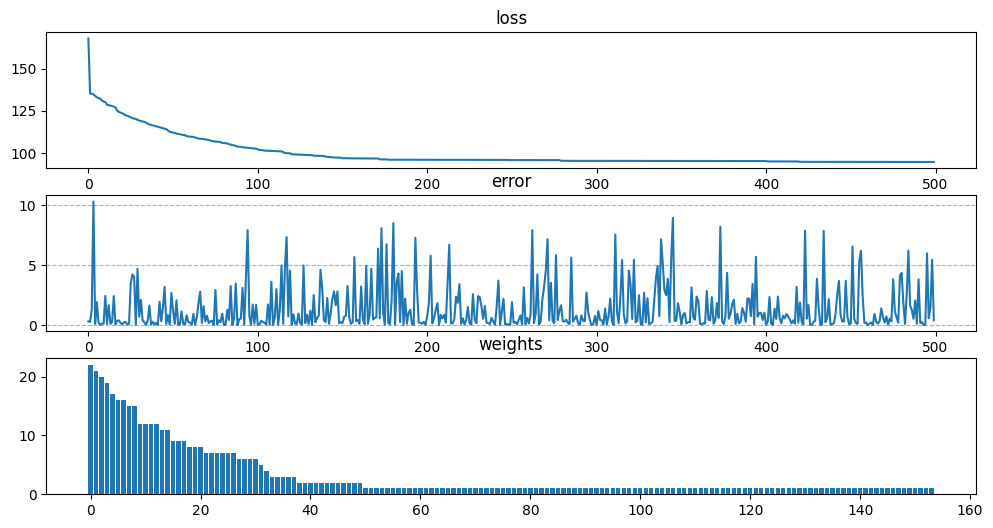

In [51]:
fig, ax = plt.subplots(3, figsize=(12, 6))
ax[0].plot(*zip(*r["losses"].items()))
ax[0].set_title("loss")
ax[1].plot(*zip(*r["errors"].items()))
ax[1].set_title("error")
# ax[1].set_yscale('log')
# ax[0].set_ylim(0, 1000)
# ax[1].set_ylim(0, 200)
# ax[1].set_ylim(0, 2000)
# ax[1].set_ylim(0, 200)
# ax[1].set_ylim(0, 20)
ax[1].grid(axis="y", ls="--")

weights = np.bincount(np.array(list(r["coords"].values())).squeeze())
weights = sorted(weights[weights > 0], reverse=True)
ax[2].bar(np.arange(len(weights)), weights)
ax[2].set_title("weights")

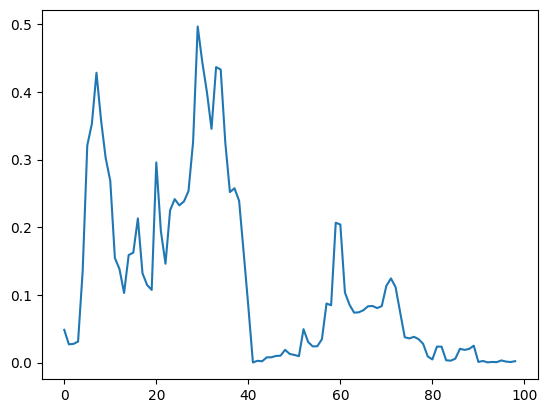

In [45]:
plt.plot([get_error(x_b, y_b, x_s, y_s, r['weights'], k) for k in range(1, 100)])

In [180]:
costs

array([3., 3., 1., ..., 1., 2., 1.], dtype=float32)